In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from textwrap import wrap
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr
import pickle

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *
from alvra_tools.XAS_functions import *
from sfdata import SFScanInfo

import warnings
warnings.filterwarnings('ignore')

<a id='Load_data'></a>
## Load data

In [2]:
pgroup = 'p20537'
Loaddir_name = 'Reduced_XES_pink_Rot'

runlist = [153]

########################################################################

Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]

titlestring_stack = pgroup + ' -- ' + str(runlist)
scan = SFScanInfo(firstrun)
all_spectra_on = []
all_spectra_off = []
for run in runlist:
    filename = glob.glob(Loaddir+'*{:04d}*/run_array.npy'.format(run))[0]
    run_array = np.load(filename, allow_pickle=True).item()
    print (filename)
    for key in run_array.keys():
        spectra_on = run_array[key]["spectra_on"]
        spectra_off  = run_array[key]["spectra_off"]
        ROIs  = run_array[key]["ROIs"]
        meta = run_array[key]["meta"]
    all_spectra_on.extend(spectra_on)
    all_spectra_off.extend(spectra_off)
print ('----------------------')
print (str(runlist) + ' --- {} acquisitions'.format(len(all_spectra_on)))

/sf/alvra/data/p20537/work/Claudio/Reduced_XES_pink_Rot/run0153-XES_pink_7200eV_2ps/run_array.npy
----------------------
[153] --- 21 acquisitions


In [3]:
s_on = {}
s_off = {}
for ROI in ROIs:
    if 'bkg' in ROI:
        continue
    son = []
    soff = []
    for i in range(len(all_spectra_on)):
        son.append(all_spectra_on[i][ROI])
        soff.append(all_spectra_off[i][ROI])
    son = np.array(np.average(son, axis=0))
    soff = np.array(np.average(soff, axis=0))
    s_on[ROI] = son
    s_off[ROI] = soff

No energy calibration file found!


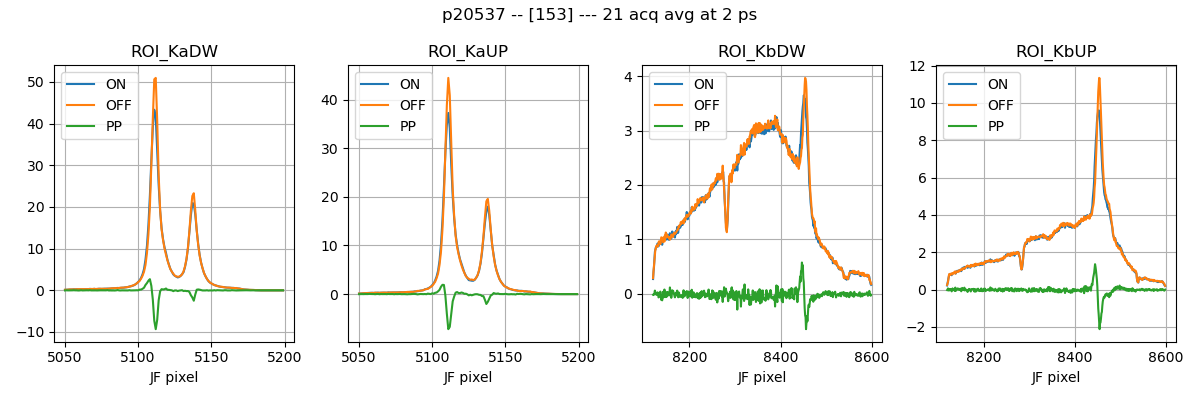

In [4]:
energy_calib = False
Loaddir = '/das/work/p20/p20537/Claudio/Reduced_XES_pink_Rot/'

energy_Loss = False
#elastic = elastic

bin_ = 1

########################################
try:
    with open(Loaddir+'Energy_calib/calibration.pkl', 'rb') as f:
        calibration = pickle.load(f)
except:
    print ('No energy calibration file found!')
    
fig, axs = plt.subplots(nrows=1, ncols=len(ROIs[0::1]), figsize=(12,4))
plt.suptitle(titlestring_stack+' --- {} acq avg at 2 ps'.format(len(all_spectra_on)))
for i, (ROI, ax) in enumerate(zip(ROIs[0::1], axs.flatten())):
    spec2plot_on = s_on[ROI]
    spec2plot_off = s_off[ROI]
    plt.sca(ax)
        
    xaxis = np.arange(np.array(meta[ROI+'-roi']).flatten()[-2], np.array(meta[ROI+'-roi']).flatten()[-1], 1)
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spec2plot_on, spec2plot_off, xaxis, bin_)
    xlabel = 'JF pixel'
    if energy_calib:
        m,b = calibration[ROI]
        x_axis_rebin = m*x_axis_rebin + b
        xlabel = 'Emission energy (eV)'
        print (m,b)
        
    if energy_Loss:
        x_axis_rebin = elastic - x_axis_rebin
        plt.gca().invert_xaxis()
        xlabel = 'Energy loss (eV)'
    
    plt.plot(x_axis_rebin, spectrum_ON_rebin, label = 'ON')
    plt.plot(x_axis_rebin, spectrum_OFF_rebin, label = 'OFF')
    plt.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label = 'PP')
    
    
    # if elastic[0] == 3003.4:
    #     plt.ylim(-0.0005, 0.005)
    # elif elastic[0] == 3004.2:
    #plt.ylim(-0.005, 0.01)
    #plt.xlim(15, -5)
    #plt.xlim(1250,1450)
    
    #plt.plot(x_axis_rebin, spectrum_OFF_rebin, label = 'OFF')    
    plt.legend (loc='upper left')
    plt.title(ROI.split(':')[-1])
    plt.xlabel(xlabel)
    plt.grid()
plt.tight_layout()


In [161]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_RIXS/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)
save_data_XES_ROIs(reducedir, run_name, s_on, s_off, ROIs, meta)
print (reducedir+run_name) 


../Claudio/Reduced_RIXS/averaged/run0278-RIXS_CpRh_25ps_3004p2eV


In [4]:
pgroup = 'p20537'
runlist = [152]
Loaddir_folder = 'Reduced_XES_pink_Rot'

##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_folder)
titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 1 runs: [152] from /sf/alvra/data/p20537/work/Claudio/Reduced_XES_pink_Rot/


['/sf/alvra/data/p20537/work/Claudio/Reduced_XES_pink_Rot/run0152-XES_pink_7200eV_2ps/run_array.npy']

No energy calibration file found!
['/das/work/p20/p20537/Claudio/Reduced_XES_pink_Rot/run0152-XES_pink_7200eV_2ps/']


TypeError: list indices must be integers or slices, not str

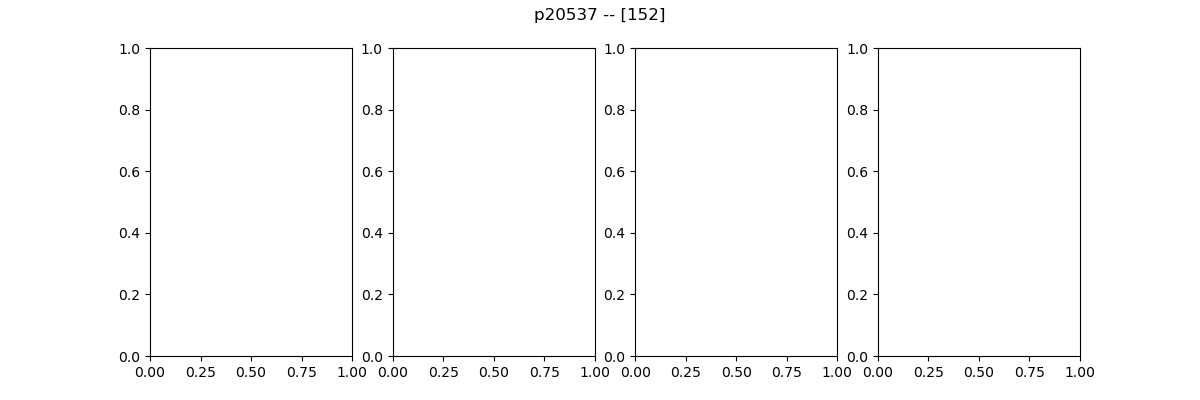

In [10]:
energy_calib = False
Loaddir_calib = '../Claudio/Reduced_RIXS/'

energy_Loss = False

bin_ = 1

########################################
try:
    with open(Loaddir_calib+'Energy_calib/calibration.pkl', 'rb') as f:
        calibration = pickle.load(f)
except:
    print ('No energy calibration file found!')
    
fig, axs = plt.subplots(nrows=1, ncols=len(ROIs[0::1]), figsize=(12,4))
plt.suptitle(titlestring_stack)
if 'averaged' in Loaddir:
    plt.suptitle(titlestring_stack+' --- {} acq avg at {}'.format(len(all_spectra_on), t_delay))
    
counter = 0
labels = ['CpRh(CO)$_2$', 'Cp*Rh(CO)$_2$', 'Rh(acac)(CO)$_2$']
for run in runlist:
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    print (path)
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        spectra_on  = run_array[key]["spectra_on"]
        spectra_off = run_array[key]["spectra_off"]
        ROIs  = run_array[key]["ROIs"]
        meta  = run_array[key]["meta"]
  
        for i, (ROI, ax) in enumerate(zip(ROIs[0::1], axs.flatten())):
            spec2plot_on = spectra_on[ROI]
            spec2plot_off = spectra_off[ROI]
            plt.sca(ax)

            xaxis = np.arange(np.array(meta[ROI+'-roi']).flatten()[-2], np.array(meta[ROI+'-roi']).flatten()[-1], 1)
            x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spec2plot_on, spec2plot_off, xaxis, bin_)
            xlabel = 'JF pixel'
            if energy_calib:
                m,b = calibration[ROI]
                x_axis_rebin = m*x_axis_rebin + b
                xlabel = 'Emission energy (eV)'
            #    print (m,b)

            if energy_Loss:
                elastic = np.float32(path[0].split('/')[-2].split('_')[-1][:-2].replace('p', '.'))
                x_axis_rebin = elastic - x_axis_rebin
                plt.gca().invert_xaxis()
                xlabel = 'Energy loss (eV)'

            #plt.plot(x_axis_rebin, spectrum_ON_rebin, label = 'ON')
            #plt.plot(x_axis_rebin, spectrum_OFF_rebin, label = 'OFF')
            plt.plot(x_axis_rebin, (spectrum_ON_rebin - spectrum_OFF_rebin)/np.max((spectrum_ON_rebin - spectrum_OFF_rebin))+2-counter, label = labels[counter])
            
            #plt.plot(x_axis_rebin, spectrum_OFF_rebin, label = 'OFF')    
            #plt.grid()
            plt.legend (loc='upper left',frameon=False,fontsize=10,labelcolor='linecolor', handletextpad= 0.0, handlelength= 0.0)
            plt.title(ROI.split(':')[-1])
            plt.xlabel(xlabel)
            plt.ylim(-0.2, 3.2)
            plt.xlim(15, -5)
        print (elastic)
    counter += 1
plt.tight_layout()
plt.show()

['/sf/alvra/data/p21211/work/Claudio/Reduced_RIXS/averaged/run0160-RIXS_CpStRh_25ps_3004p2eV/']
3004.2
['/sf/alvra/data/p21211/work/Claudio/Reduced_RIXS/averaged/run0228-RIXS_RhAcac_25ps_3004p4eV/']
3004.4


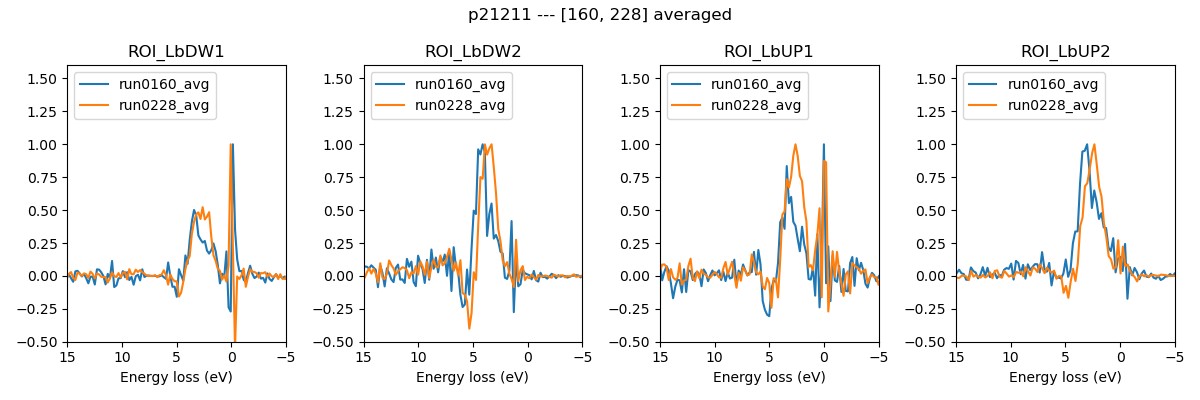

In [369]:
energy_calib = True
Loaddir_calib = '../Claudio/Reduced_RIXS/'

energy_Loss = True

bin_ = 1

########################################
try:
    with open(Loaddir_calib+'Energy_calib/calibration.pkl', 'rb') as f:
        calibration = pickle.load(f)
except:
    print ('No energy calibration file found!')
    
fig, axs = plt.subplots(nrows=1, ncols=len(ROIs[0::1]), figsize=(12,4))
plt.suptitle(titlestring_stack)
if 'averaged' in Loaddir:
    plt.suptitle(titlestring_stack + ' averaged')

    # norm = [1,2.2]
    
for num, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    print (path)
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        spectra_on  = run_array[key]["spectra_on"]
        spectra_off = run_array[key]["spectra_off"]
        ROIs  = run_array[key]["ROIs"]
        meta  = run_array[key]["meta"]
  
        for i, (ROI, ax) in enumerate(zip(ROIs[0::1], axs.flatten())):
            spec2plot_on = spectra_on[ROI]
            spec2plot_off = spectra_off[ROI]
            plt.sca(ax)

            xaxis = np.arange(np.array(meta[ROI+'-roi']).flatten()[-2], np.array(meta[ROI+'-roi']).flatten()[-1], 1)
            x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spec2plot_on, spec2plot_off, xaxis, bin_)
            xlabel = 'JF pixel'
            if energy_calib:
                m,b = calibration[ROI]
                x_axis_rebin = m*x_axis_rebin + b
                xlabel = 'Emission energy (eV)'
            #    print (m,b)

            if energy_Loss:
                elastic = np.float32(path[0].split('/')[-2].split('_')[-1][:-2].replace('p', '.'))
                x_axis_rebin = elastic - x_axis_rebin
                plt.gca().invert_xaxis()
                xlabel = 'Energy loss (eV)'
            diff = (spectrum_ON_rebin - spectrum_OFF_rebin)
            #plt.plot(x_axis_rebin, spectrum_ON_rebin, label = 'ON')
            #plt.plot(x_axis_rebin, spectrum_OFF_rebin, label = 'OFF')
            plt.plot(x_axis_rebin, diff/np.max(diff), label = runnumber)
            
            #plt.plot(x_axis_rebin, spectrum_OFF_rebin, label = 'OFF')    
            plt.grid()
            plt.legend (loc='upper left')
            plt.title(ROI.split(':')[-1])
            plt.xlabel(xlabel)
            plt.ylim(-0.5, 1.6)
            plt.xlim(15, -5)
        print (elastic)
plt.tight_layout()
plt.show()

os.makedirs('/sf/alvra/data/p21211/work/victoria/', exist_ok=True)
#fig.savefig('/sf/alvra/data/p21211/work/victoria/figure.pdf')

In [11]:
ROIs

['JF02T09V03:ROI_KaDW',
 'JF02T09V03:ROI_KaUP',
 'JF02T09V03:ROI_KbDW',
 'JF02T09V03:ROI_KbUP']

No energy calibration file found!


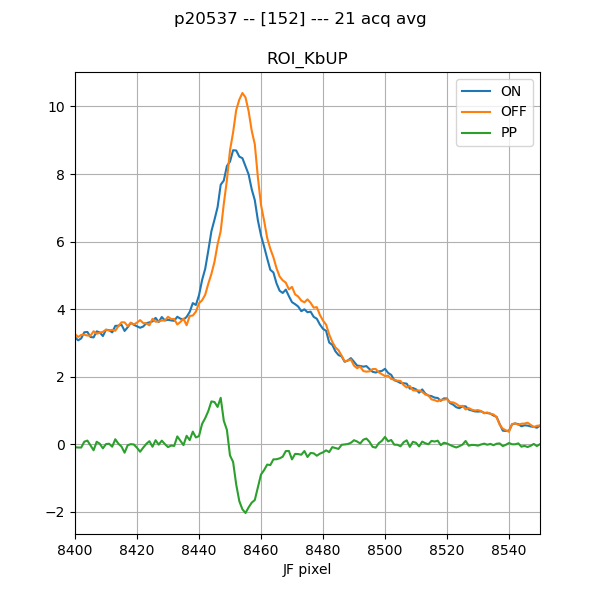

In [15]:
ROI = 'JF02T09V03:ROI_KbUP'

energy_calib = False
Loaddir = '../Claudio/Reduced_RIXS/'

energy_Loss = False
elastic = 3002.8

bin_ = 1

vmin = None
vmax = None

##########################################################
try:
    with open(Loaddir+'Energy_calib/calibration.pkl', 'rb') as f:
        calibration = pickle.load(f)
except:
    print ('No energy calibration file found!')

plt.figure(figsize=(6,6))
plt.suptitle(titlestring_stack+' --- {} acq avg'.format(len(spectra_on)))
xlabel = 'JF pixel'
spec2plot_on = s_on[ROI]
spec2plot_off = s_off[ROI]
xaxis = np.arange(np.array(meta[ROI+'-roi']).flatten()[-2], np.array(meta[ROI+'-roi']).flatten()[-1], 1)
x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spec2plot_on, spec2plot_off, xaxis, bin_)
if energy_calib:
    m,b = calibration[ROI]
    x_axis_rebin = m*x_axis_rebin + b
    xlabel = 'Emission energy (eV)'
    
if energy_Loss:
    x_axis_rebin = elastic - x_axis_rebin
    plt.gca().invert_xaxis()
    xlabel = 'Energy loss (eV)'

plt.plot(x_axis_rebin, spectrum_ON_rebin, label = 'ON')
plt.plot(x_axis_rebin, spectrum_OFF_rebin, label = 'OFF')
plt.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label = 'PP')

plt.legend (loc='best')
plt.title(ROI.split(':')[-1])
plt.xlabel(xlabel)
#plt.ylim(-0.002, 0.005)
plt.xlim(8400, 8550)
plt.grid()

plt.show()

In [ ]:
ROIs

In [ ]:
def clean_ROI_names (channels_ROI):
    for ROIname in channels_ROI:
        if "bkg" in ROIname:
            channels_ROI.remove(ROIname)
    return channels_ROI

In [ ]:
ROIs = clean_ROI_names(ROIs)
ROIs